## Разведочный анализ данных (EDA)

**Будет использоваться датасет `jigsaw-toxic-comment-classification-challenge`**

### Подготовка к работе

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Набор данных добавлялся в Kaggle следующим образом:
* В правой панели, в разделе **input** нажатие на **Add Input**
* Выбор категории **Datasets**
* Выбор `jigsaw-toxic-comment-classification-challenge` от **Julián Peller**
* Добавление датасета через **add** (нажатие на плюс)

In [2]:
# Назначаем датафрейм
df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv")

In [3]:
# Проверка "головы" набора данных (первые 5 записей)
print(df.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [4]:
# Информация о данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


### Визуализация распределения классов

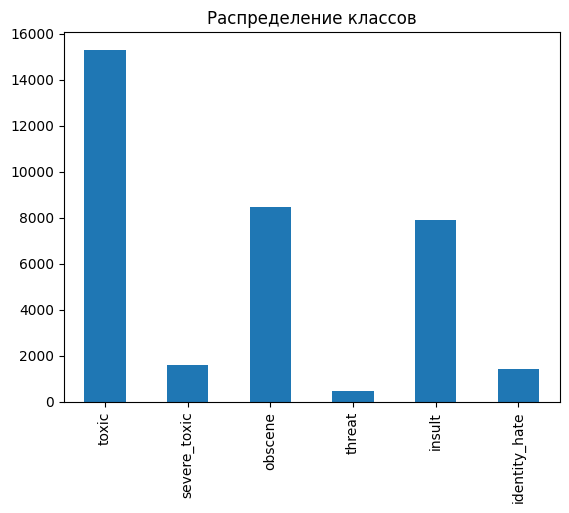

In [5]:
# Распределение классов
toxicity_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df[toxicity_cols].sum().plot(kind='bar', title='Распределение классов')  # Создание графика
plt.show()  # Отображение графика

Сразу же можно отметить сильный дизбаланс классов.

### Визуализация длины текстов

Теперь создадим для каждой записи в датасете столбец, содержащий длину текста.

In [6]:
# Новый столбец с длиной текста
df['text_length'] = df['comment_text'].apply(len)

Визуализируем

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


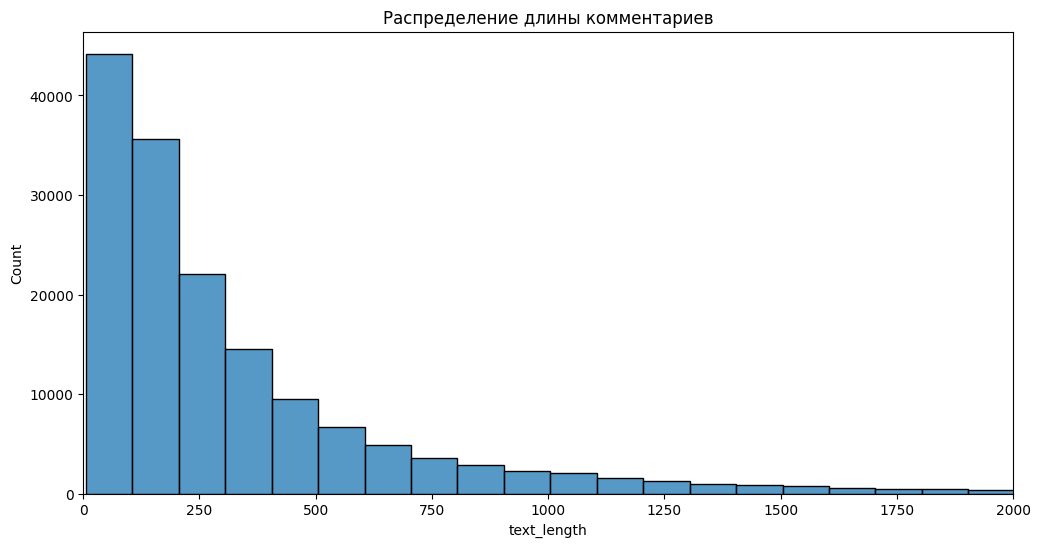

In [7]:
# Визуализация распределения длин текстов
plt.figure(figsize=(12,6))
sns.histplot(df['text_length'], bins=50)  # Гистограмма с 50 столбцами
plt.title('Распределение длины комментариев')
plt.xlim(0, 2000)  # Ограничить редкие огромные значения для улучшения визуализации
plt.show()

Если здесь есть предупреждение – ничего страшного, просто на данный момент Kaggle по умолчанию импортирует устаревшую версию seaborn и возникает предупреждение об обратной совместимости. На деле это ничему не мешает.

Чтобы посмотреть, о чём могут быть самые длинные комментарии и при этом не засорять экран, можно применить HTML прямо в ячейке вывода Kaggle.

In [8]:
from IPython.display import HTML

In [9]:
# 3 наиболее длинных комментария
top_long_comm = df.nlargest(3, 'text_length')

In [10]:
# Стили для div
container_style="margin: 5px 0; border: 1px solid #ddd; border-radius: 5px; padding: 10px;"
content_style = """max-height: 200px;
              overflow: auto;
              padding: 10px;
              background: #f8f9fa;
              border-left: 3px solid #4CAF50;
              margin: 10px 0;
           """

# Каждый комментарий – разворачиваемое окошко высотой 200 с прокруткой
for i, row in top_long_comm.iterrows():
    display(HTML(f"""
    <div style="{container_style}">
    <details>
    <summary style='font-weight: bold;'>
    Комментарий #{i} (Длина: {row['text_length']} симв.)
    </summary>
    <div style="{content_style}">
    {row['comment_text']}
    </div>
    </details>
    </div>
    """))

In [11]:
# Создаем общую метку "токсичность"
df['any_toxic'] = df[toxicity_cols].max(axis=1)  # toxicity_cols мы назначали выше

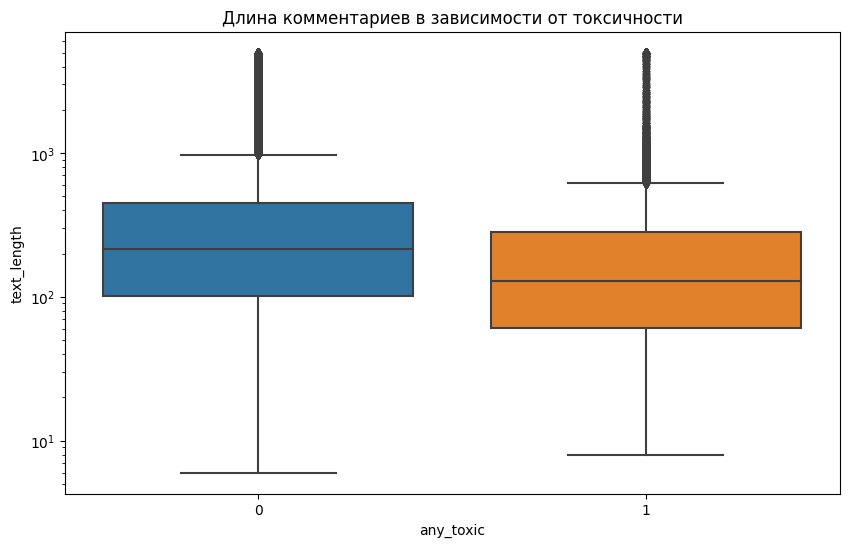

In [12]:
# Боксплоты для сравнения
plt.figure(figsize=(10,6))
sns.boxplot(x='any_toxic', y='text_length', data=df)
plt.title('Длина комментариев в зависимости от токсичности')
plt.yscale('log')  # Логарифмическая шкала (иначе будет выглядеть плохо)
plt.show()

На этом графике видно, что в среднем "не токсичные комментарии" где-то на 20% длиннее "токсичных", это довольно значительно.<br>
Исходя из этого можно, например, использовать длину текста как один из признаков (features).

### Облако слов

Реализуем облако слов для каждой категории "токсичности".

In [13]:
from wordcloud import WordCloud

In [14]:
import base64
from io import BytesIO

Помимо самого облака, нам понадобятся дополнительные библиотеки `base64` и `BytesIO`  для улучшения визуализации.<br>
Поскольку сами облака слов довольно крупные и целиком состоят из грубостей, я счёл уместным их компактно "спрятать", чтобы их по желанию можно было развернуть.<br>
Коротко о реализации:
* Создаётся фигура с облаком слов
* Изображение сохраняется в буфер памяти
* Затем изображение кодируется в строку base64 для вставки в HTML
* Процесс итеративно повторяется для всех классов


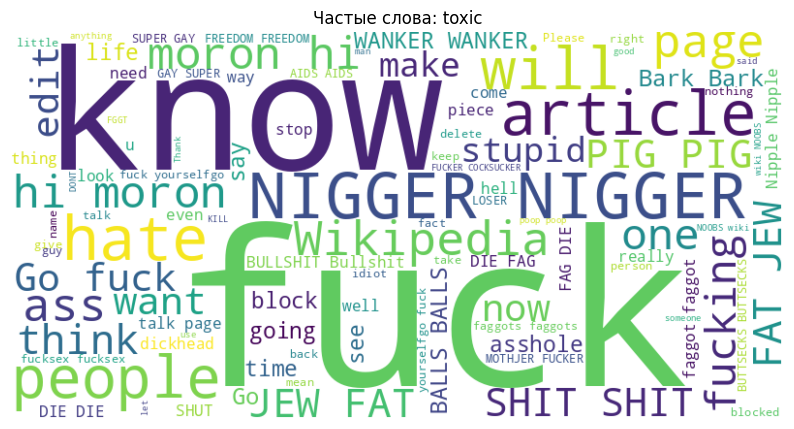
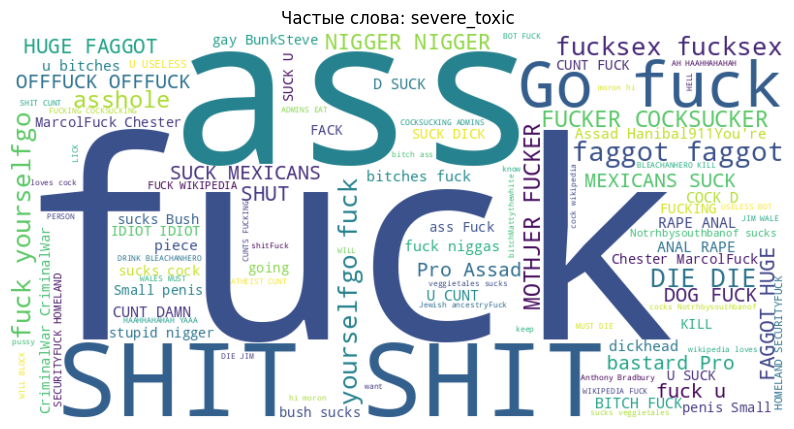
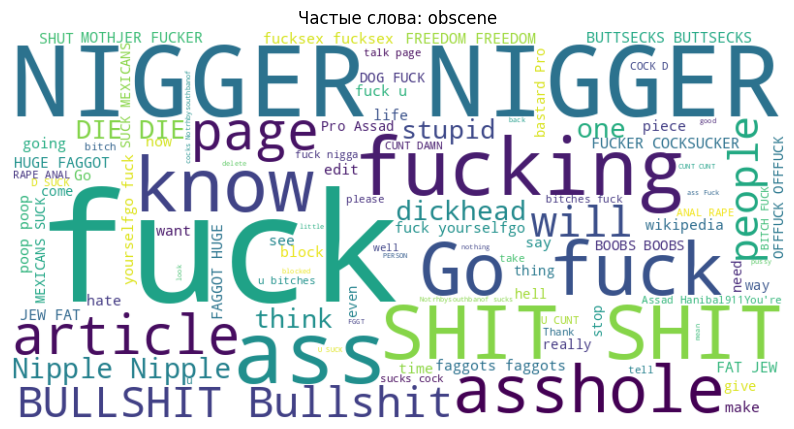
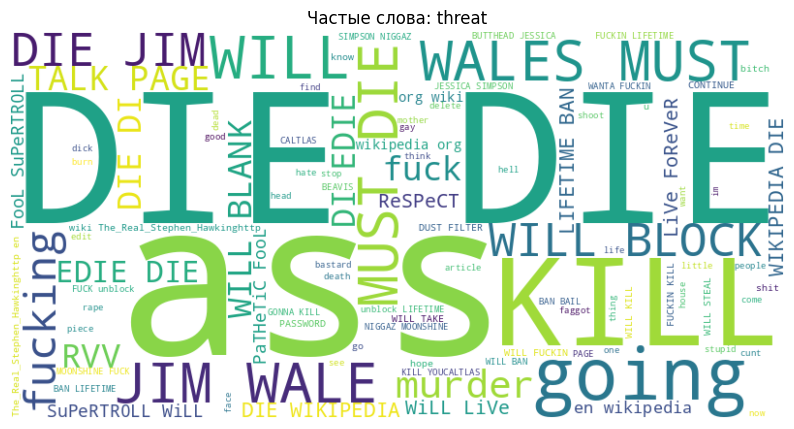
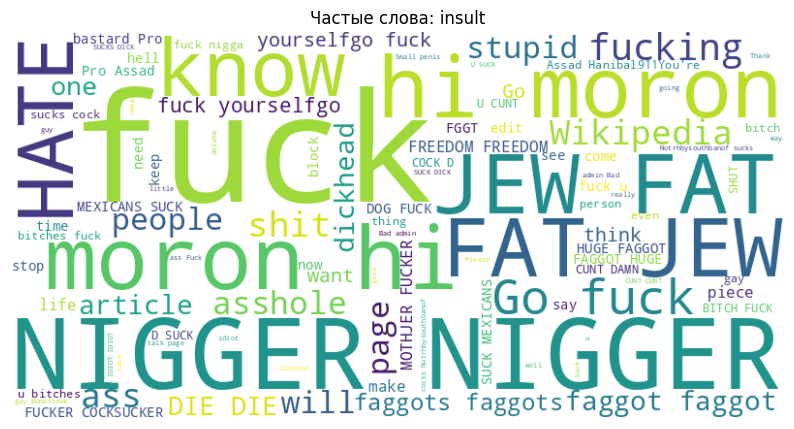
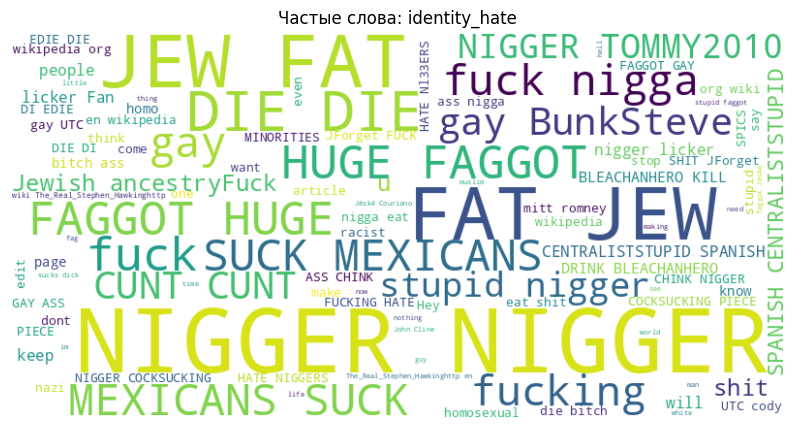

In [15]:
# Функция генерации "облака слов" для каждого класса – категории токсичности
def generate_wordcloud(class_name):
    subset = df[df[class_name]==1]  # Фильтрация данных по классу
    text = " ".join(comment for comment in subset.comment_text)  # Объединение с учётом частоты слов
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)  # Генерация "облака слов"

    # Создание изображения "облака слов", чтобы потом сохранить его
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Частые слова: {class_name}')
    
    # Сохраняем изображение в буфер
    buf = BytesIO()  # Создаём в оперативной памяти "переменную" под файл
    plt.savefig(buf, format='png', bbox_inches='tight')  # Копируем файл в оперативную память
    plt.close()  # Закрываем фигуру – очищаем память
    buf.seek(0)  # "Перематываем" буфер в начало перед чтением (перемещаем "курсор чтения")
    
    # Кодируем в base64
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')  # Кодирование для HTML
    
    # Генерируем строку-HTML со "спойлером" и предупреждением
    return f"""
    <div style="{container_style}">
    <details>
    <summary style='font-weight: bold;'>
    Показать облако слов: {class_name} (содержимое может быть оскорбительным)
    </summary>
    <img src='data:image/png;base64,{img_base64}' style='width: 100%'>
    </details>
    </div>
    """

# Генерируем и отображаем "спойлеры" для всех классов
html_output = ""
for col in toxicity_cols:
    html_output += generate_wordcloud(col)

display(HTML(html_output))

### Корреляция меток

Посмотрим, как коррелируют между собой различные классы токсичности (метки).

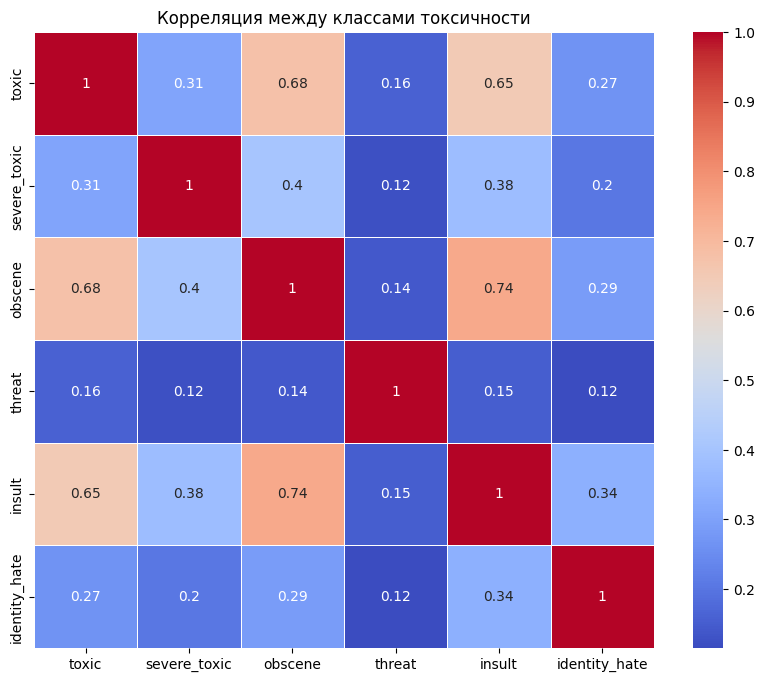

In [16]:
# Матрица корреляций меток (toxicity_cols)
corr_matrix = df[toxicity_cols].corr()

# Тепловая карта
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,  # Аннотации (числовые значения в ячейках)
            cmap="coolwarm",  # Красно-синяя цветовая схема
            linewidths=.5)  # Линии между ячейками
plt.title('Корреляция между классами токсичности')
plt.show()

Из матрицы корреляции видно, что "Непристойные выражения" (**obscene**), оскорбления (**insult**), и "токсичность" (**toxic**) коррелируют между собой в диапазоне `0.65-0.74`. Эти классы по сути своей менее "самобытные" - их особенности пересекаются. Даже человек бы не всегда точно разграничил insult и toxic.

У угроз (**threat**), "сильной токсичности" (**severe_toxic**) и ненависти на основе идентичности (**identity_hate**) – уникальные слова встречаются чаще и более "уловимы", отсюда и корреляции не выше `0.4`. А у **threat** вообще корреляция с каким-либо классом не превышает `0.16`.

### Примеры самых "токсичных" и самых "нейтральных" комментариев

Создадим столбец "суммарной токсичности" – сложением всех значений из `toxicity_cols`.

In [17]:
# Создаем новый столбец "toxicity_score"
df['toxicity_score'] = df[toxicity_cols].sum(axis=1)  # axis 1 – значения по горизонтали (для каждой строки)

In [18]:
# Самые токсичные – ищем 5 строк с наибольшими значениями в столбце toxicity_score
toxic_samples = df.nlargest(5, 'toxicity_score')[['comment_text', 'toxicity_score']]

Значения в квадратных скобках: `[['comment_text', 'toxicity_score']]` – фильтры для столбцов, то есть остаются только текст комментария и "счёт".

In [19]:
# Самые нейтральные
neutral_samples = df[df['toxicity_score']==0].sample(5)[['comment_text', 'toxicity_score']]

`df['toxicity_score']==0:` создаёт булеву маску для строк, где "счет" токсичности равен 0

Отображение образцов:

In [20]:
# Функция форматирования
def format_comments(samples):
    total_text = []
    # Итерации по образцам, взятие текста и "скора тоскичности"
    for i, row in samples.iterrows():
        score = f" (toxicity_score={row['toxicity_score']})"
        text = row['comment_text']
        # Обрезка длинных комментариев
        if len(text) > 500:
            text = text[:500] + "(...)"
        total_text.append(f"<b>Комментарий #{i}{score}:</b><br>{text}<br>")  # <br> – перенос строки
    return "<br>".join(total_text)

# Применяем к обоим наборам образцов функцию
toxic_html = format_comments(toxic_samples)
neutral_html = format_comments(neutral_samples)

# Создаем конструкции со "спойлерами", повторно применяем стиль "my_style" для div
html_output = f"""
<div style="{container_style}">
<details>
<summary style='font-weight: bold;'>Нейтральные образцы (toxicity_score = 0)</summary>
<div style="{content_style}">
{neutral_html}
</div>
</details>
</div>

<div style="{container_style}">
<details>
<summary style='font-weight: bold;'>Самые токсичные образцы (максимальный toxicity_score)</summary>
<div style="{content_style}">
{toxic_html}
</div>
</details>
</div>
"""

display(HTML(html_output))

## Основные выводы EDA

1. **Дисбаланс классов**
   * Наблюдается значительный дисбаланс классов. Например, `threat` в 20 раз реже `toxic`.

2. **Длина комментариев**
   * Токсичные комментарии в среднем короче
   * Максимальная длина 5000 символов – потребуется обрезка для ML модели

3. **Корреляция меток**
   * Сильная связь межу toxic, insult и obscene
   * Незначительная связь severe_toxic и identity_hate с остальными классами
   * Слабая связь threat с другими классами